In [1]:

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as sig

os.chdir(os.path.dirname(os.getcwd()))
import spatial_metrics.helper_functions as hf
import spatial_metrics.cell_model_base as cs_model
import spatial_metrics.spatial_metrics_calcium_base as pl

import spatial_metrics.detect_peaks as dp
import spatial_metrics.spatial_prediction_calcium_base as sp
import scipy.stats as stats


In [4]:

srate = 100. # points/frames per second
total_Time = 1000 # in seconds
_lambda = 10 # how much your neuron should spike
environment_edges = [[0,100],[0,100]] # in cm [[x1,x2],[y1,y2]]

x_coordinates,y_coordinates,speed,timevector = cs_model.generate_random_walk(input_srate = srate,input_total_Time = total_Time,heading_srate = 10., speed_srate = 5., rho1  = 1,sigma = 0.02,mu_e  = 0.,smooth_coeff = 0.5,environment_edges = environment_edges)
total_points = timevector.shape[0]

timestamps = cs_model.generate_arrivals(_lambda,total_Time)
I_timestamps = (timestamps*srate).astype(int)

# place cell with one field: x_center and y_center is the location of the place field in ehe environment; s is the field variance
modulated_timestamps = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 35,y_center = 25, s = 500)

# grid cell with several fields
# modulated_timestamps1 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 50,y_center = 50, s = 5)
# modulated_timestamps2 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 10,y_center = 10, s = 5)
# modulated_timestamps3 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 10,y_center = 90, s = 5)
# modulated_timestamps4 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 90,y_center = 90, s = 5)
# modulated_timestamps5 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 90,y_center = 10, s = 5)
# modulated_timestamps = np.unique(np.concatenate([modulated_timestamps1,modulated_timestamps2,modulated_timestamps3,modulated_timestamps4,modulated_timestamps5]))

# if you want to control for the amount of spikes, set a fixed value for spikes
# num_of_spikes = 50
# modulated_timestamps = np.sort(np.random.choice(modulated_timestamps,num_of_spikes,replace=False))

calcium_imag,timevector = cs_model.generate_calcium_signal(modulated_timestamps,total_points,srate,noise_level = 0.01, b = 5.)
calcium_events = modulated_timestamps.shape[0]
I_peaks = dp.detect_peaks(calcium_imag,mpd=0.5*srate,mph=1.*np.nanstd(calcium_imag))

# modulated_timestamps = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 80,y_center = 80, s = 5)
# calcium_imag2,timevector = cs_model.generate_calcium_signal(modulated_timestamps,total_points,srate,noise_level = 0.01, b = 5.)
# calcium_events = modulated_timestamps.shape[0]
# I_peaks = dp.detect_peaks(calcium_imag,mpd=0.5*srate,mph=1.*np.nanstd(calcium_imag))


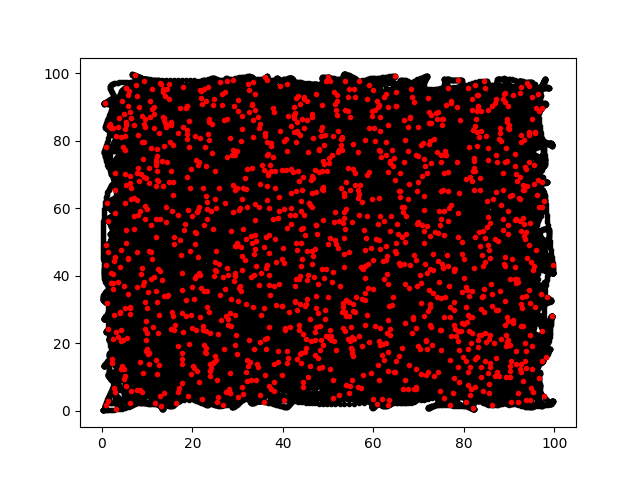

In [5]:

input_variable = np.vstack([calcium_imag,calcium_imag2])
input_variable = calcium_imag

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k.')
plt.plot(x_coordinates[I_peaks],y_coordinates[I_peaks],'r.')
plt.show()

In [7]:

srate = 1/np.nanmean(np.diff(timevector))

input_dict = dict()
input_dict['saving_string'] = 'SpatialPrediction.Original'
input_dict['animal_id'] = 'NeuronModel'
input_dict['day'] = 1
input_dict['neuron'] = 1
input_dict['trial'] = None
input_dict['dataset'] = 'Simulation'
input_dict['mean_video_srate'] = srate
input_dict['min_time_spent'] = 0
input_dict['min_visits'] = 0
input_dict['min_speed_threshold'] = 0 
input_dict['x_bin_size'] = 2
input_dict['y_bin_size'] = 2
input_dict['environment_edges'] = environment_edges
input_dict['shift_time'] = 100
input_dict['num_cores'] = 20
input_dict['num_surrogates'] = 10
input_dict['saving_path'] = None
input_dict['saving'] = False
input_dict['num_of_folds'] = 10

spatial_prediction_object = sp.SpatialPrediction(**input_dict)
spatial_prediction_output = spatial_prediction_object.main(input_variable,timevector,x_coordinates,y_coordinates)

spatial_prediction_object_surr = sp.SpatialPredictionSurrogates(**input_dict)
spatial_prediction_output_surr = spatial_prediction_object_surr.main(input_variable,timevector,x_coordinates,y_coordinates)


File not saved!
File not saved!


In [8]:
spatial_prediction_output.keys()

dict_keys(['concat_accuracy', 'concat_continuous_error', 'concat_mean_error', 'spatial_error', 'spatial_error_smoothed', 'x_grid', 'y_grid', 'x_center_bins', 'y_center_bins', 'numb_events', 'events_index', 'events_amp', 'events_x_localization', 'events_y_localization', 'input_parameters'])

In [6]:
spatial_prediction_output_surr.keys()

dict_keys(['concat_accuracy', 'concat_continuous_error', 'concat_mean_error', 'spatial_error', 'spatial_error_smoothed', 'x_grid', 'y_grid', 'x_center_bins', 'y_center_bins', 'numb_events', 'events_index', 'events_amp', 'events_x_localization', 'events_y_localization', 'input_parameters'])

In [ ]:


plt.figure()
plt.pcolormesh(spatial_prediction_output['x_center_bins'],spatial_prediction_output['y_center_bins'],spatial_prediction_output['spatial_error'],cmap='jet')
plt.colorbar()
plt.show()



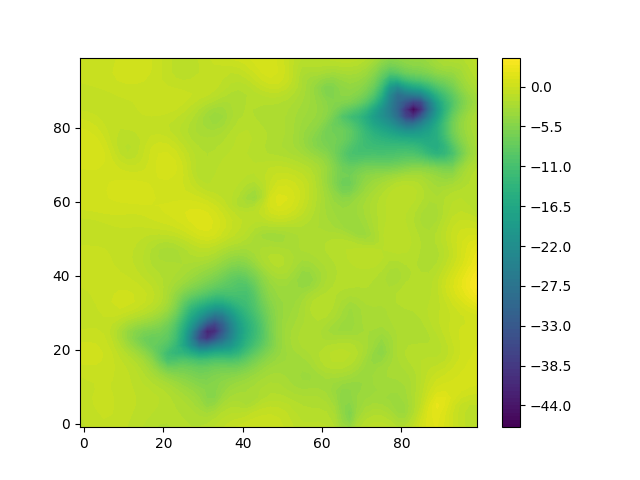

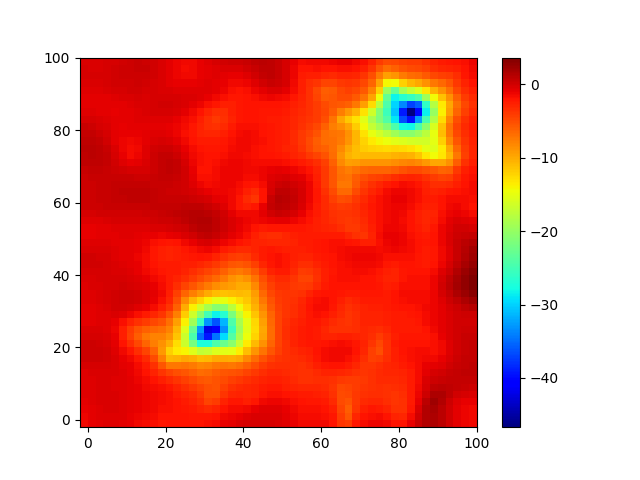

In [25]:

spatial_error_surr = np.array(spatial_prediction_output_surr['spatial_error_smoothed'])
spatial_error_original = spatial_prediction_output['spatial_error_smoothed']
spatial_error_zscored = (spatial_error_original-np.nanmean(spatial_error_surr,0))/np.nanstd(spatial_error_surr,0)

plt.figure()
plt.contourf(spatial_prediction_output_surr['x_center_bins'],spatial_prediction_output_surr['y_center_bins'],spatial_error_zscored,100)
plt.colorbar()
plt.show()


plt.figure()
plt.pcolormesh(spatial_prediction_output_surr['x_center_bins'],spatial_prediction_output_surr['y_center_bins'],spatial_error_zscored,cmap='jet')
plt.colorbar()
plt.show()



In [70]:

input_dict = { 'saving_string':None,
                'animal_id':'NeuronModel',
                'day':1,
                'neuron':1,
                'trial':None,
                'dataset':'Simulation',
                'mean_video_srate':srate,
                'min_time_spent':0,
                'min_visits':0,
                'min_speed_threshold':0, 
                'x_bin_size':1,
                'y_bin_size':1,
                'environment_edges':environment_edges,
                'shift_time':100,
                'num_cores':20,
                'num_surrogates':10,
                'saving_path':[],
                'saving':False
}

place_cell = pl.PlaceCell(**input_dict)
place_cell_output = place_cell.main(calcium_imag,timevector,x_coordinates,y_coordinates)


/home/apolo/Documents/GitHubProjects/Information_Metrics/spatial_metrics/spatial_metrics_base.py:277: RuntimeWarning: Mean of empty slice
  place_field[yy, xx] = np.nanmean(calcium_imag[np.logical_and(check_x_occupancy, check_y_occupancy)])


.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved


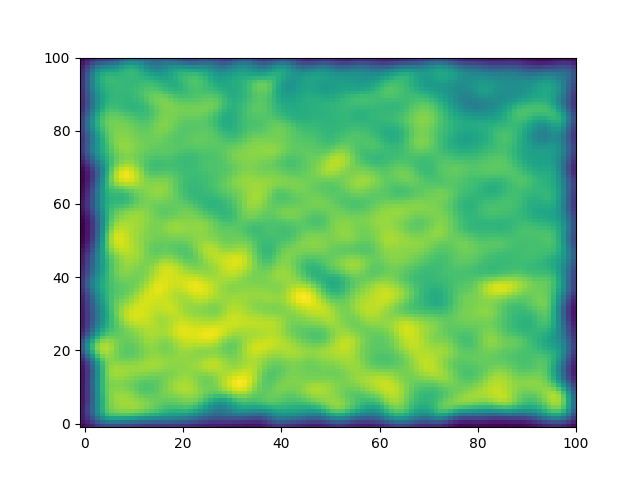

In [71]:

plt.figure()
plt.pcolormesh(place_cell_output['x_grid'],place_cell_output['y_grid'],place_cell_output['place_field_smoothed'])
plt.show()


In [58]:

spatial_prediction_output_surr.keys()


dict_keys(['concat_accuracy', 'concat_continuous_error', 'concat_mean_error_classic', 'spatial_error_classic', 'smoothed_spatial_error_classic', 'concat_continuous_error_center_of_mass', 'concat_mean_error_center_of_mass', 'spatial_error_center_of_mass', 'smoothed_spatial_center_of_mass', 'numb_events', 'events_index', 'events_amp', 'events_x_localization', 'events_y_localization', 'x_grid', 'y_grid', 'x_center_bins', 'y_center_bins', 'input_parameters'])

In [17]:
# simulation to get the mean error from 2 random points in the enviroment
all_dist = []
for _ in range(1000):
    x1_points = np.random.choice(np.arange(float(environment_edges[0][0]),float(environment_edges[0][1]),0.1),100)
    y1_points = np.random.choice(np.arange(float(environment_edges[1][0]),float(environment_edges[1][1]),0.1),100)

    x2_points = np.random.choice(np.arange(float(environment_edges[0][0]),float(environment_edges[0][1]),0.1),100)
    y2_points = np.random.choice(np.arange(float(environment_edges[1][0]),float(environment_edges[1][1]),0.1),100)

    dist = np.sqrt((x1_points - x2_points)**2 + (y1_points-y2_points)**2)[0]
    all_dist.append(dist)
np.nanmean(all_dist)


52.24376244602377

In [18]:
# simulation to get the mean error from 2 random points using the coordinates
all_dist = []
for _ in range(1000):
    rand_pt1 = np.random.choice(range(x_coordinates.shape[0]),1)
    rand_pt2 = np.random.choice(range(y_coordinates.shape[0]),1)

    dist = np.sqrt((x_coordinates[rand_pt1] - x_coordinates[rand_pt2])**2 + (y_coordinates[rand_pt1]-y_coordinates[rand_pt2])**2)[0]
    all_dist.append(dist)
np.nanmean(all_dist)


50.9973190147034

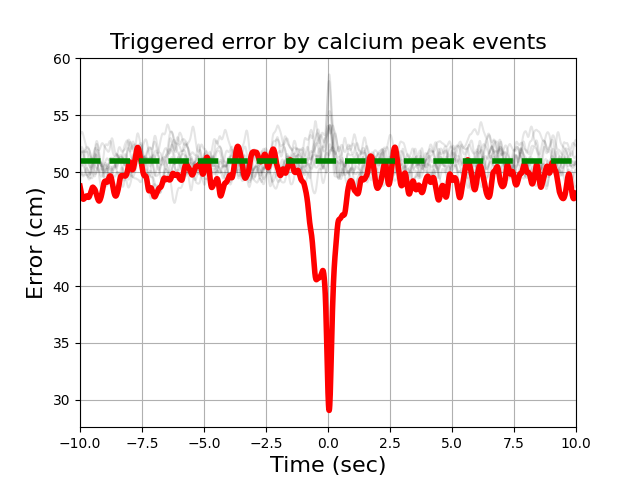

In [19]:
num_surrogates = spatial_prediction_output_surr['input_parameters']['num_surrogates']

cell = 0
event_window_size = 10


plot_window = np.arange(np.floor(-event_window_size*srate),np.floor(event_window_size*srate))/srate

smoothed_error = hf.smooth(spatial_prediction_output['concat_continuous_error'],window_len=30)
I_peaks = spatial_prediction_output['events_index'][cell]

triggered_error_original = []
triggered_calcium = []
for ii in I_peaks:
    if ((ii - event_window_size*srate) > 0) and (ii + event_window_size*srate < smoothed_error.shape[0]):
        error_window = np.arange(np.floor(ii - event_window_size*srate),np.floor(ii + event_window_size*srate)).astype(int)
        triggered_error_original.append(smoothed_error[error_window])
triggered_error_original = np.array(triggered_error_original)
mean_triggered_error_original = np.nanmean(triggered_error_original,0)


triggered_error_surr = []
for surr in range(num_surrogates):
    smoothed_error = hf.smooth(spatial_prediction_output_surr['concat_continuous_error'][surr],window_len=30)
    I_peaks = spatial_prediction_output_surr['events_index'][surr][cell]
        
    triggered_error_aux = []
    for ii in I_peaks:
        if ((ii - event_window_size*srate) >= 0) and (ii + event_window_size*srate < smoothed_error.shape[0]):
            error_window = np.arange(np.floor(ii - event_window_size*srate),np.floor(ii + event_window_size*srate)).astype(int)
            triggered_error_aux.append(smoothed_error[error_window])
    triggered_error_surr.append(np.nanmean(np.array(triggered_error_aux),0))
triggered_error_surr = np.array(triggered_error_surr)


plt.figure()
plt.plot(plot_window,triggered_error_surr.T,'k',alpha=0.1)
plt.plot(plot_window,mean_triggered_error_original,'r',linewidth=4)
plt.plot([-event_window_size,event_window_size],[np.nanmean(all_dist),np.nanmean(all_dist)],'g--',linewidth=4)
plt.grid()
plt.ylabel('Error (cm)',fontsize=16)
plt.xlabel('Time (sec)',fontsize=16)
plt.xlim([-event_window_size,event_window_size])
plt.title('Triggered error by calcium peak events',fontsize=16)
plt.show()


In [21]:
np.nanmean(spatial_prediction_output['concat_continuous_error'] - spatial_prediction_output_surr['concat_continuous_error'][7])



-1.9152599121505665

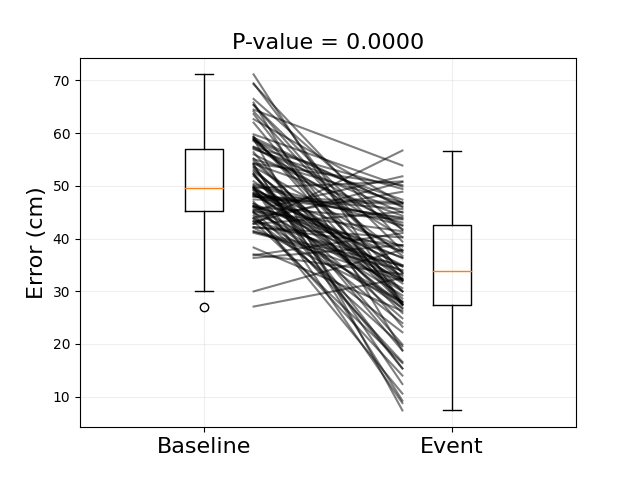

In [22]:
# checking significance of the triggered error

I_pre_window = np.where((plot_window>= -4) & (plot_window < -3.5))[0]
I_pos_window = np.where((plot_window>= 0) & (plot_window < 0.25))[0]

mean_triggered_error_original_baseline = np.nanmean(triggered_error_original[:,I_pre_window],1)
mean_triggered_error_original_event = np.nanmean(triggered_error_original[:,I_pos_window],1)

t_dependent,pval = stats.ttest_rel(mean_triggered_error_original_baseline,mean_triggered_error_original_event,alternative='greater')
effect_size = t_dependent/np.sqrt(mean_triggered_error_original_baseline.shape[0])
mean_difference = np.nanmean(mean_triggered_error_original_event) - np.nanmean(mean_triggered_error_original_baseline)
pval

plt.figure()
plt.boxplot([mean_triggered_error_original_baseline,mean_triggered_error_original_event])
plt.plot([1.2,1.8],[mean_triggered_error_original_baseline,mean_triggered_error_original_event],'k-',alpha=0.5)
# plt.ylim([10,90])
plt.grid(alpha=0.2)
plt.ylabel('Error (cm)',fontsize=16)
plt.xticks([1,2],labels=['Baseline','Event'],fontsize=16)
plt.title("P-value = {0:0.4f}".format(pval),fontsize=16)
plt.show()


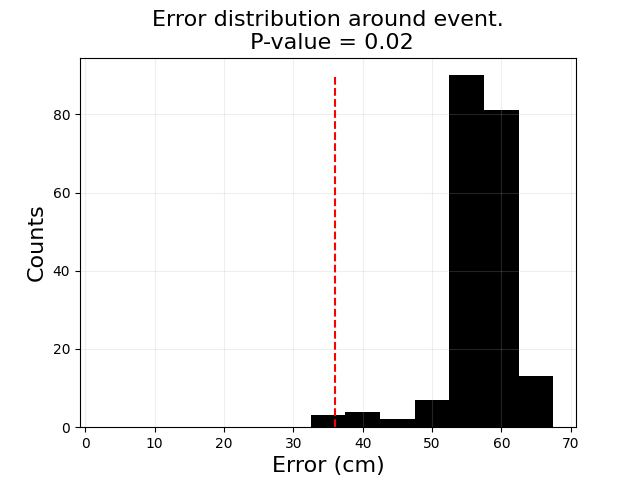

In [301]:

I_event_window = np.where((plot_window>= 0) & (plot_window < 0.5))[0]

mean_triggered_error_original_event = np.nanmean(triggered_error_original[:,I_event_window])
mean_triggered_error_surr_event = np.nanmean(triggered_error_surr[:,I_event_window],1)
pvalue = np.sum(mean_triggered_error_surr_event<mean_triggered_error_original_event)/num_surrogates
if pvalue == 0:
    pvalue = 1/num_surrogates

error_step = 5
error_bins = np.arange(0,np.ceil(np.nanmax(mean_triggered_error_surr_event))+error_step/2,error_step)
error_counts,bins = np.histogram(mean_triggered_error_surr_event,error_bins)
center_error_bins = error_bins[0:-1] + np.diff(error_bins)

plt.figure()
plt.bar(center_error_bins,error_counts,width=error_step,color='black')
plt.plot([mean_triggered_error_original_event,mean_triggered_error_original_event],[0,np.nanmax(error_counts)],'r--')
plt.ylabel('Counts',fontsize=16)
plt.xlabel('Error (cm)',fontsize=16)
plt.title('Error distribution around event.\n P-value = {0:.2f}'.format(pvalue),fontsize=16)
plt.grid(alpha=0.2)
plt.show()






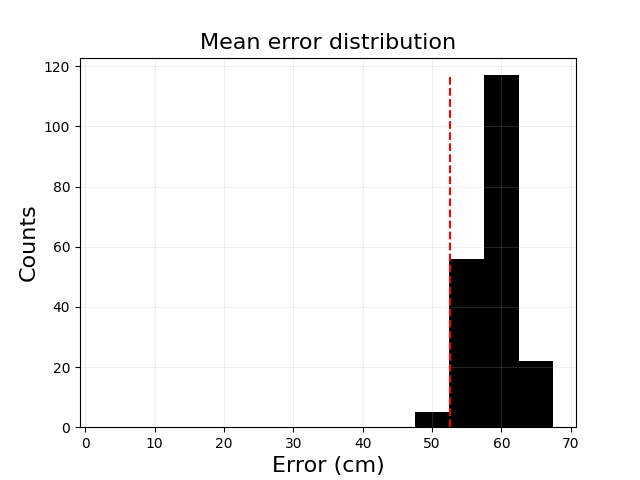

In [172]:
mean_error = np.nanmean(spatial_prediction_output['concat_mean_error_classic'])
mean_error_surr = np.nanmean(np.array(spatial_prediction_output_surr['concat_mean_error_classic']),1)

error_step = 5
error_bins = np.arange(0,np.ceil(np.nanmax(mean_error_surr))+error_step/2,error_step)
error_counts,bins = np.histogram(mean_error_surr,error_bins)
center_error_bins = error_bins[0:-1] + np.diff(error_bins)

plt.figure()
plt.bar(center_error_bins,error_counts,width=error_step,color='black')
plt.plot([mean_error,mean_error],[0,np.nanmax(error_counts)],'r--')
plt.ylabel('Counts',fontsize=16)
plt.xlabel('Error (cm)',fontsize=16)
plt.title('Mean error distribution',fontsize=16)
plt.grid(alpha=0.2)
plt.show()


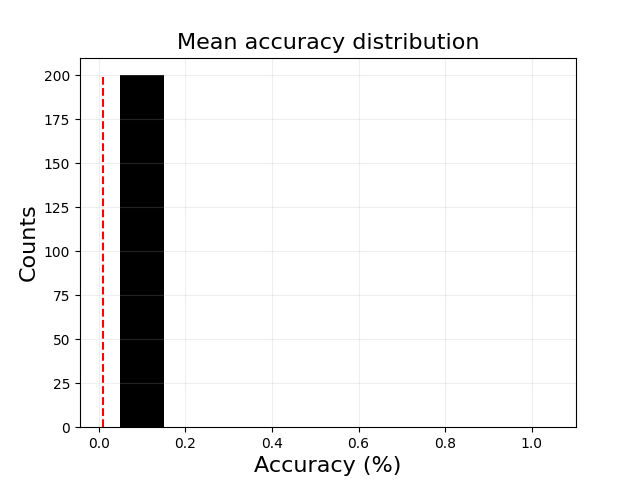

In [173]:

concat_accuracy = spatial_prediction_output['concat_accuracy']
concat_accuracy_surr = np.array(spatial_prediction_output_surr['concat_accuracy'])

bin_step = 0.1
accuracy_bins = np.arange(0,1+bin_step/2,bin_step)
accuracy_counts,bins = np.histogram(np.nanmean(concat_accuracy_surr,1),accuracy_bins)
center_accuracy_bins = accuracy_bins[0:-1] + np.diff(accuracy_bins)

mean_accuracy = np.nanmean(concat_accuracy)

plt.figure()
plt.bar(center_accuracy_bins,accuracy_counts,width=bin_step,color='black')
plt.plot([mean_accuracy,mean_accuracy],[0,np.nanmax(accuracy_counts)],'r--')
plt.ylabel('Counts',fontsize=16)
plt.xlabel('Accuracy (%)',fontsize=16)
plt.title('Mean accuracy distribution',fontsize=16)
plt.grid(alpha=0.2)
plt.show()


In [ ]:

mean_spatial_error_classic = np.nanmean(np.array(spatial_prediction_output_surr['smoothed_spatial_error_classic']),0)
std_spatial_error_classic = np.nanstd(np.array(spatial_prediction_output_surr['smoothed_spatial_error_classic']),0)
spatial_prediction_output_zscored = (spatial_prediction_output['smoothed_spatial_error_classic']-mean_spatial_error_classic)/std_spatial_error_classic

orig_map=plt.cm.get_cmap('viridis')
reversed_map = orig_map.reversed()

plt.figure()
plt.pcolormesh(spatial_prediction_output['x_center_bins'],spatial_prediction_output['y_center_bins'],spatial_prediction_output_zscored,cmap=reversed_map)
plt.plot(spatial_prediction_output['events_x_localization'],spatial_prediction_output['events_y_localization'],'r.')
plt.colorbar()
plt.title('Smoothed Error Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.show()


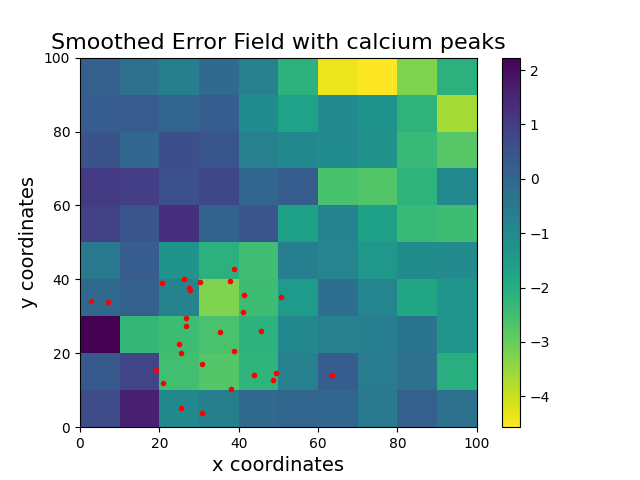

In [49]:
mean_spatial_error_classic = np.nanmean(np.array(spatial_prediction_output_surr['spatial_error_classic']),0)
std_spatial_error_classic = np.nanstd(np.array(spatial_prediction_output_surr['spatial_error_classic']),0)
spatial_prediction_output_zscored = (spatial_prediction_output['spatial_error_classic']-mean_spatial_error_classic)/std_spatial_error_classic

orig_map=plt.cm.get_cmap('viridis')
reversed_map = orig_map.reversed()

plt.figure()
plt.pcolormesh(spatial_prediction_output['x_center_bins'],spatial_prediction_output['y_center_bins'],spatial_prediction_output_zscored,cmap=reversed_map)
plt.plot(spatial_prediction_output['events_x_localization'],spatial_prediction_output['events_y_localization'],'r.')
plt.colorbar()
plt.title('Smoothed Error Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.show()


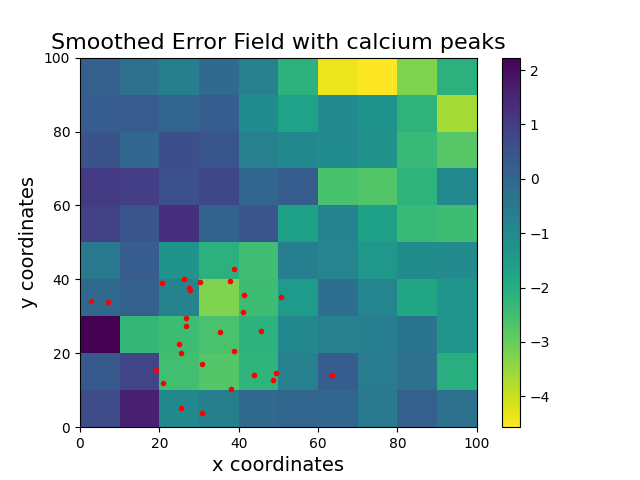

In [49]:
mean_spatial_error_classic = np.nanmean(np.array(spatial_prediction_output_surr['spatial_error_classic']),0)
std_spatial_error_classic = np.nanstd(np.array(spatial_prediction_output_surr['spatial_error_classic']),0)
spatial_prediction_output_zscored = (spatial_prediction_output['spatial_error_classic']-mean_spatial_error_classic)/std_spatial_error_classic

orig_map=plt.cm.get_cmap('viridis')
reversed_map = orig_map.reversed()

plt.figure()
plt.pcolormesh(spatial_prediction_output['x_center_bins'],spatial_prediction_output['y_center_bins'],spatial_prediction_output_zscored,cmap=reversed_map)
plt.plot(spatial_prediction_output['events_x_localization'],spatial_prediction_output['events_y_localization'],'r.')
plt.colorbar()
plt.title('Smoothed Error Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.show()


In [42]:
spatial_prediction_output_surr.keys()

dict_keys(['concat_accuracy', 'concat_continuous_error', 'concat_mean_error_classic', 'spatial_error_classic', 'smoothed_spatial_error_classic', 'concat_continuous_error_center_of_mass', 'concat_mean_error_center_of_mass', 'spatial_error_center_of_mass', 'smoothed_spatial_center_of_mass', 'numb_events', 'events_index', 'events_amp', 'events_x_localization', 'events_y_localization', 'x_grid', 'y_grid', 'x_center_bins', 'y_center_bins'])

In [7]:
spatial_prediction_output.keys()

dict_keys(['concat_accuracy', 'concat_continuous_error', 'concat_mean_error_classic', 'spatial_error_classic', 'smoothed_spatial_error_classic', 'concat_continuous_error_center_of_mass', 'concat_mean_error_center_of_mass', 'spatial_error_center_of_mass', 'smoothed_spatial_center_of_mass', 'x_grid', 'y_grid', 'x_center_bins', 'y_center_bins', 'numb_events', 'events_index', 'events_amp', 'events_x_localization', 'events_y_localization', 'input_parameters'])

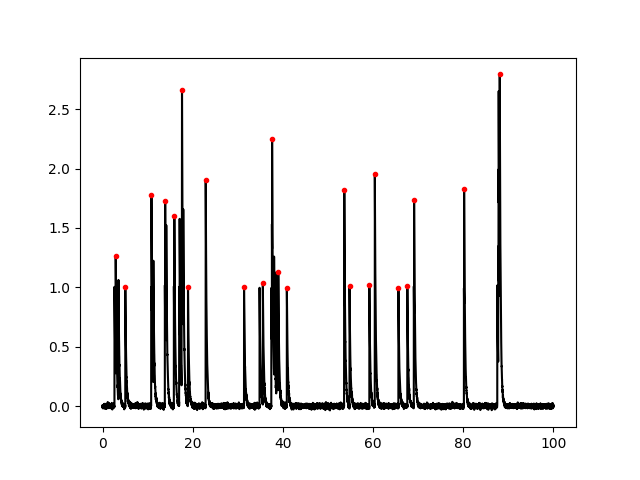

In [36]:
I_peaks = dp.detect_peaks(calcium_imag,mpd=1*srate,mph=1*np.nanstd(calcium_imag))

plt.figure()
plt.plot(timevector,calcium_imag,'k')
plt.plot(timevector[I_peaks],calcium_imag[I_peaks],'r.')
plt.show()


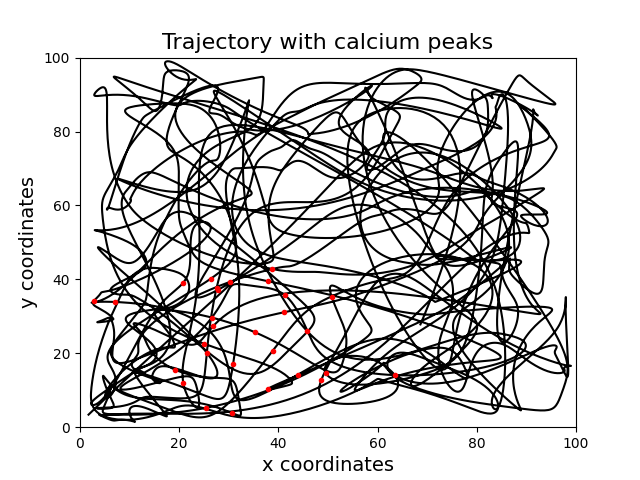

In [37]:
events_index = spatial_prediction_output['events_index']

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k',alpha=1)
# plt.plot(x_coordinates[events_index],y_coordinates[events_index],'r.')
plt.plot(spatial_prediction_output['events_x_localization'],spatial_prediction_output['events_y_localization'],'r.')
plt.title('Trajectory with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.show()


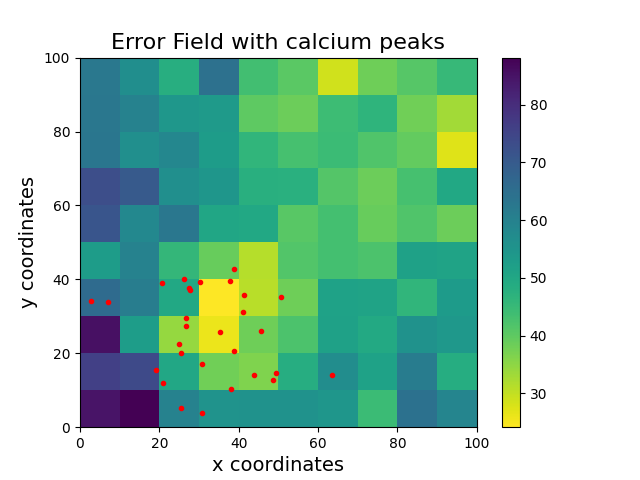

In [38]:

orig_map=plt.cm.get_cmap('viridis')
reversed_map = orig_map.reversed()

plt.figure()
plt.pcolormesh(spatial_prediction_output['x_center_bins'],spatial_prediction_output['y_center_bins'],spatial_prediction_output['spatial_error_classic'],cmap=reversed_map)
plt.plot(spatial_prediction_output['events_x_localization'],spatial_prediction_output['events_y_localization'],'r.')
plt.colorbar()
plt.title('Error Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.show()


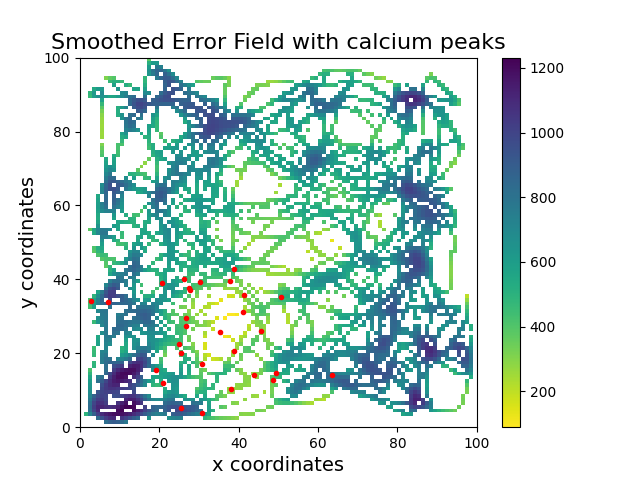

In [11]:
 
orig_map=plt.cm.get_cmap('viridis')
reversed_map = orig_map.reversed()

plt.figure()
plt.pcolormesh(spatial_prediction_output['x_center_bins'],spatial_prediction_output['y_center_bins'],spatial_prediction_output['smoothed_spatial_error_classic'],cmap=reversed_map)
plt.plot(spatial_prediction_output['events_x_localization'],spatial_prediction_output['events_y_localization'],'r.')
plt.colorbar()
plt.title('Smoothed Error Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.show()


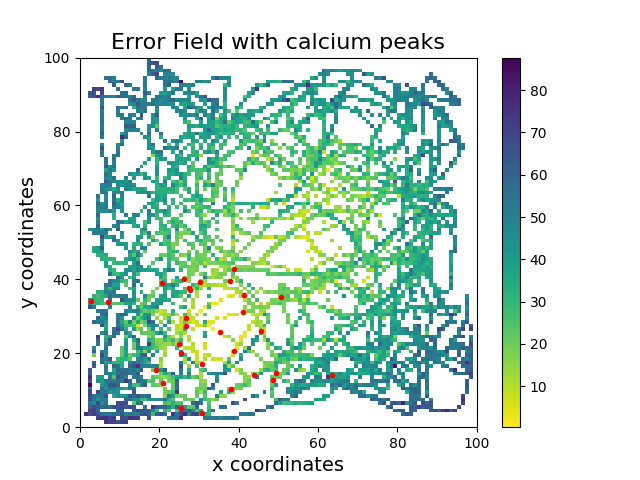

In [12]:
orig_map=plt.cm.get_cmap('viridis')
reversed_map = orig_map.reversed()

plt.figure()
plt.pcolormesh(spatial_prediction_output['x_center_bins'],spatial_prediction_output['y_center_bins'],spatial_prediction_output['spatial_error_center_of_mass'],cmap=reversed_map)
plt.plot(spatial_prediction_output['events_x_localization'],spatial_prediction_output['events_y_localization'],'r.')
plt.colorbar()
plt.title('Error Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.show()


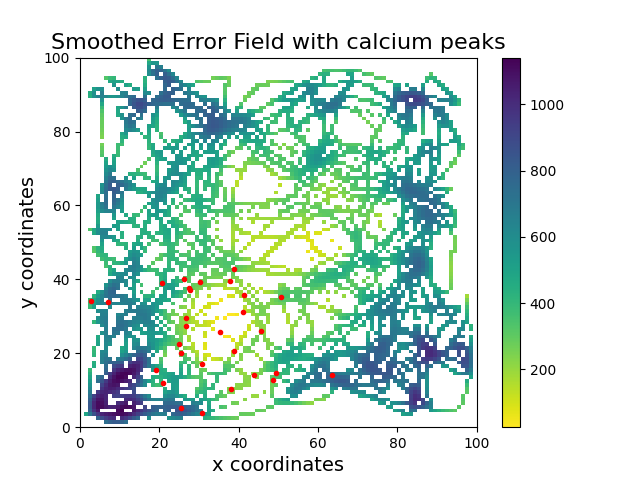

In [13]:
 
orig_map=plt.cm.get_cmap('viridis')
reversed_map = orig_map.reversed()

plt.figure()
plt.pcolormesh(spatial_prediction_output['x_center_bins'],spatial_prediction_output['y_center_bins'],spatial_prediction_output['smoothed_spatial_center_of_mass'],cmap=reversed_map)
plt.plot(spatial_prediction_output['events_x_localization'],spatial_prediction_output['events_y_localization'],'r.')
plt.colorbar()
plt.title('Smoothed Error Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.show()


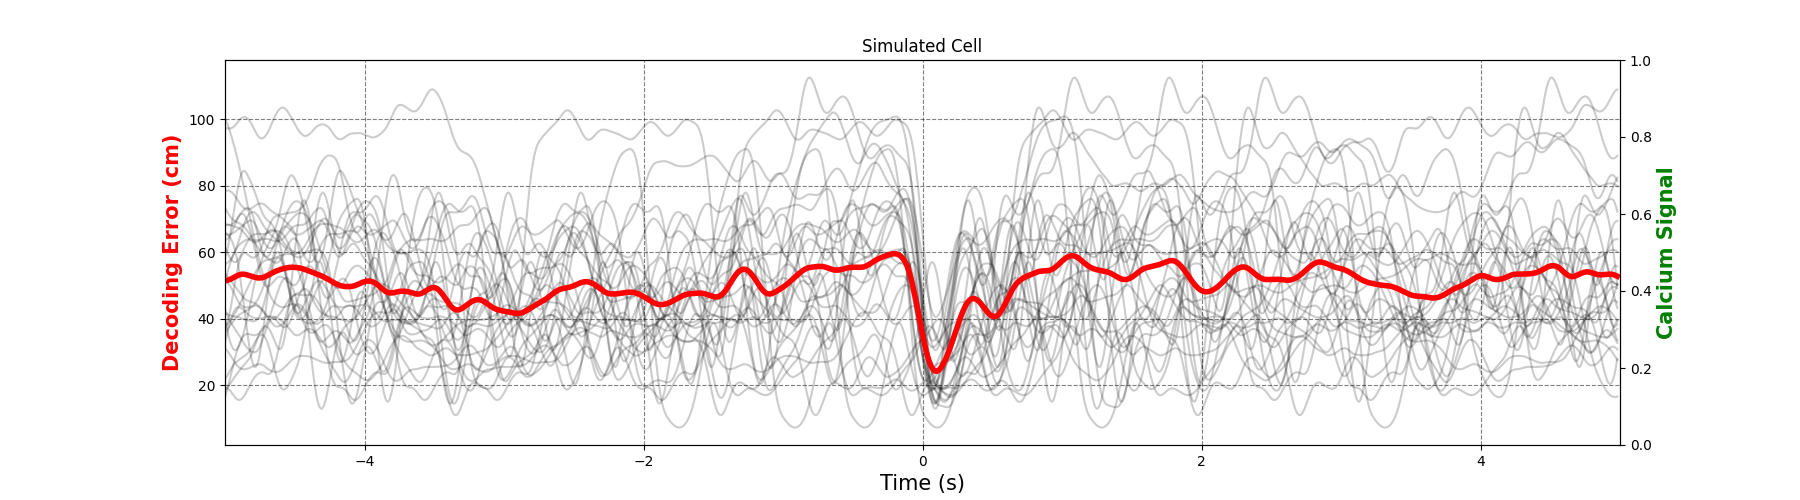

In [290]:

plt.close('all')

mean_triggered_error = np.nanmean(triggered_error_original,0)
# mean_triggered_calcium = np.nanmean(triggered_calcium_original,0)

plt.figure(figsize=(18,5))
plt.plot(plot_window,triggered_error_original.T,'k',alpha=0.2)
plt.plot(plot_window,mean_triggered_error,'r',linewidth = 4)
plt.ylabel('Decoding Error (cm)',color='red',fontsize=15,fontweight='extra bold')
plt.xlabel('Time (s)',fontsize=15)
plt.grid(color='black',linestyle = '--',alpha=0.5,zorder=10)
plt.xticks(np.arange(-10,12,2))
plt.xlim([-5,5])

plt.twinx()
# plt.plot(plot_window,mean_triggered_calcium,'g',linewidth = 4)
plt.ylabel('Calcium Signal',color='green',fontsize=15,fontweight='extra bold')
plt.title('Simulated Cell')
plt.show()



In [321]:

import matplotlib.gridspec as gridspec
    
plt.close('all')

mean_triggered_error = np.nanmean(triggered_error_original,0)
mean_triggered_calcium = np.nanmean(triggered_calcium_original,0)

plt.figure(figsize=(18,5))
gridspec.GridSpec(1,3)

plt.subplot2grid((1,3), (0,0), colspan=2, rowspan=1)
#     plt.subplot(1,2,1)
plt.plot(plot_window,triggered_error_original.T,'k',alpha=0.2)
plt.plot(plot_window,mean_triggered_error,'r',linewidth = 4)
plt.ylabel('Decoding Error (cm)',color='red',fontsize=15,fontweight='extra bold')
plt.xlabel('Time (s)',fontsize=15)
plt.grid(color='black',linestyle = '--',alpha=0.5,zorder=10)
plt.xticks(np.arange(-10,12,2))
plt.xlim([-5,5])
# plt.ylim([0,26])

plt.twinx()
plt.plot(plot_window,mean_triggered_calcium,'g',linewidth = 4)
plt.ylabel('Calcium Signal',color='green',fontsize=15,fontweight='extra bold')
plt.title('Simulated Cell')

plt.subplot2grid((1,3), (0,2))
#     plt.subplot(1,2,2)
plt.pcolormesh(PlaceCellObject['x_grid'],PlaceCellObject['y_grid'],PlaceCellObject['signalMap'])
plt.plot(x_coordinates[PlaceCellObject['events_index']],y_coordinates[PlaceCellObject['events_index']],'r.')
plt.colorbar()
# plt.clim([0,2])
#         plt.axis('scaled')
plt.title('MI = ' + str(np.round(PlaceCellObject['mutualInfo_zscored'],2)) + '; Events = ' + str(calcium_events))

plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …